In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from uedge import *
from uedge.hdf5 import *
#import plotmesh as pm
from uetools import Case
from uedge.gridue import write_gridue
from Forthon import gchange

UEDGE configuration file /Users/eliotfelske/.uetoolsrc read.


# Notes
* plate1_vert_shortleg: (x,y) coordinates of plates
* Naming scheme: filetype (gridue/converge)\_v#\_secondaryflag_divertorshape.filetype
* reconverged2 is secondary convergence pass with different bbb flags
* TODO: after converging, renaming new grid file in yaml causes fnorm to be large and not converge

# Procedure
## Use gridgen.py to create hdf5 gridue
* Aeqdsk needs the x point (rb, zb, rt, zt) coordinates at line 20
* Aeqdsk needs strike point (0, rin, zin, rout, zout) coordinates line 58,59
* Gridgen: iterate flx.psi0sep to get the flux surface through x point and strike point
* Make sure the correct plate geometry is imported
## Converge UEDGE
* Add the hdf5 grid file to the YAML input file
* Name the hdf5 save file correctly (name differently than preconverged file)
* Converge with dtreal=1e-10, if doesn't work, set bbb.gamsec = 1 (for striations issue), bbb.isbcwdt = 1 (for converging errors)
* If the initial fnrm starts increasing rapidly when time-step is ~1e-8
* If converged, change input YAML file to point to new save file, if working in the same notebook shouldn't need to

# Generate Grid

 
***  alfcy_inner has been re-defined  ***
 
 
     alfcy_inner =   2.619560E+00
 ***** Grid generation has been completed
 Wrote file "gridue" with runid:  TokaMaker:                                                  

 Wrote grid file successfully:
     file name:   reconverged_v9_diag_p20_imp_integrated.hdf5
     run-ID:      TokaMaker:
 ***** Grid generation has been completed
 Wrote file "gridue" with runid:  TokaMaker:                                                  

 Wrote grid file successfully:
     file name:   reconverged_v9_diag_p20_imp_integrated.hdf5
     run-ID:      TokaMaker:
***********************************************
** CAUTION: NOT USING METHG=66 FOR ISNONOG=1 **
***********************************************
 
***  alfcy_inner has been re-defined  ***
 
 
     alfcy_inner =   2.619560E+00
 ***** Grid generation has been completed
 Wrote file "gridue" with runid:  TokaMaker:                                                  


*** UEDGE arrays populated: WARNI

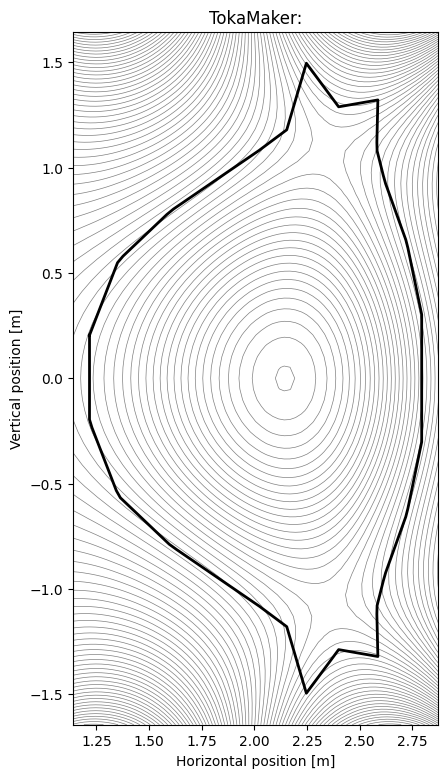

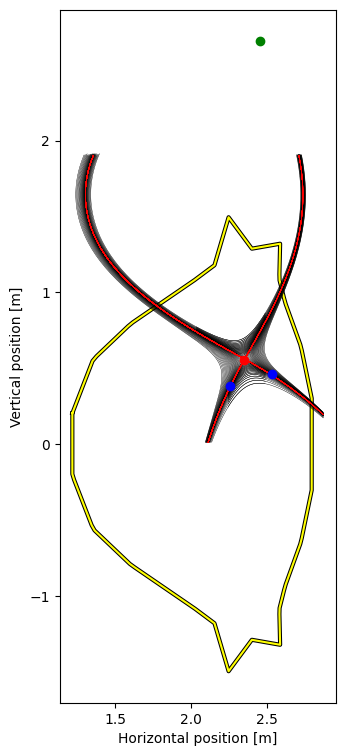

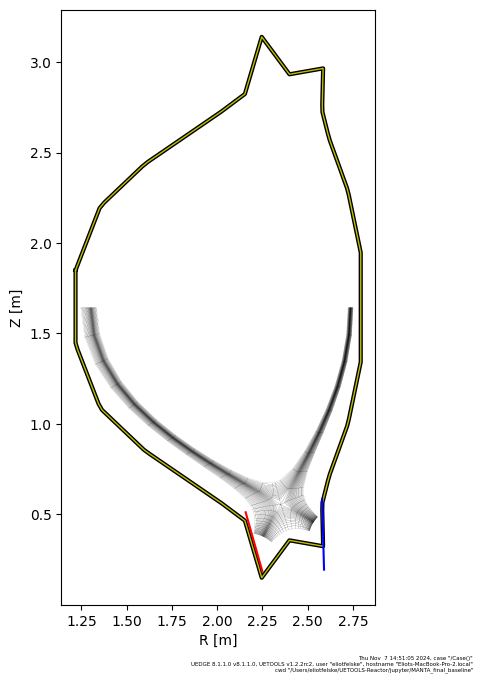

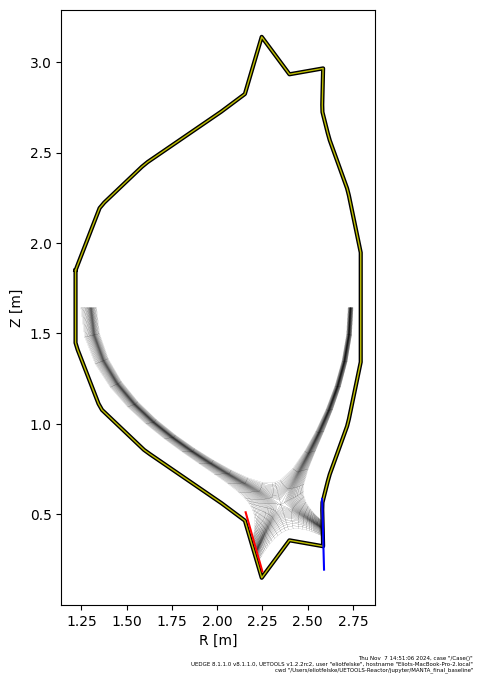

In [2]:
# %matplotlib widget
from gridgen_v9_vertical import setGrid
setGrid()

# Create Case from YAML

In [3]:
#c = Case('reconverged_v9_diag_p20_imp_integrated_ii2.hdf5')
c = Case('input_v9_psol20_imp_integrated.yaml')


No diffusivity-file supplied: reading from save-file ".../jupyter/MANTA_final_baseline/reconverged_v9_diag_p20_imp_integrated_ii2.hdf5"
  User-specified diffusivities read from HDF5 file ".../jupyter/MANTA_final_baseline/reconverged_v9_diag_p20_imp_integrated_ii2.hdf5"
UETOOLS-style save successfully restored from .../jupyter/MANTA_final_baseline/reconverged_v9_diag_p20_imp_integrated_ii2.hdf5
*** For isimpon=2, set afracs, not afrac ***

*** UEDGE arrays populated: WARNING, case NOT converged ***
fnrm without preconditioning: 7.04e+08



# Converge

In [5]:
print(bbb.isphiofft,bbb.gamsec)


0 0.0


In [4]:
c.converge(savefname='reconverged_v9_diag_p20_imp_integrated', dtreal=1e-10)


Requested save-path ../solutions not found, writing to cwd!
*----------------------------------------------------------*
 Need to take initial step with Jacobian; trying to do here 
*----------------------------------------------------------*
*** For isimpon=2, set afracs, not afrac ***
 Reading grid data from /Users/eliotfelske/UETOOLS-Reactor/jupyter/MANTA_final_baseline/gridmorph/progress53p837.hdf5
 Grid data read successfully:
     file name:   /Users/eliotfelske/UETOOLS-Reactor/jupyter/MANTA_final_baseline/gridmorph/progress53p837.hdf5
     run-ID:      TokaMaker:                                                  
  Updating Jacobian, npe =                      1
 iter=    0 fnrm=      14.07124727947029     nfe=      1
  Updating Jacobian, npe =                      2
 iter=    1 fnrm=      13.64334725264850     nfe=      4
 iter=    2 fnrm=      10.54163714456752     nfe=     12
 iter=    3 fnrm=      8.046175417929026     nfe=     19
 iter=    4 fnrm=      4.489692856820711     

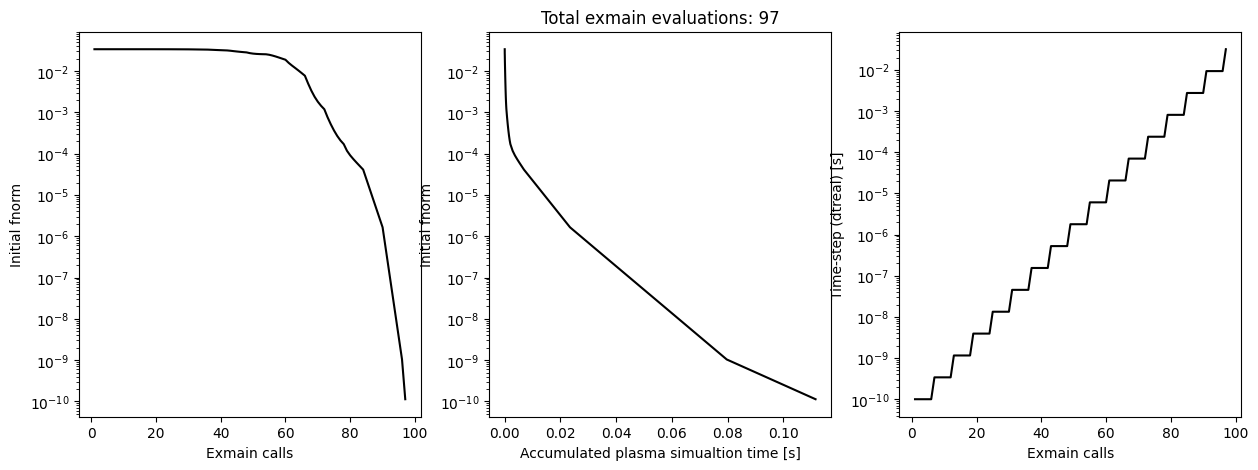

In [5]:
c.solver.convergenceanalysis('reconverged_v9_diag_p20_imp_last_ii2.hdf5');

# Gridmorph

In [6]:
c.solver.gridmorph("gridue_v9_shaped_open.hdf5", 'gridmorph2', dt=1e20)

*----------------------------------------------------------*
 Need to take initial step with Jacobian; trying to do here 
*----------------------------------------------------------*
    -Variable(s) being solved:
                                        - gridmorph
    -Progress                             0.000%
    -Advancing by                         0.100%
    -Steps to target at current delta:    1000

  Updating Jacobian, npe =                      1
 iter=    0 fnrm=     0.3096436397103467E-02 nfe=      1
  Updating Jacobian, npe =                      2

Type "cont" to continue exmain(), "abort" (not compatible with openmp) or "stop" (with openmp) to return to Python prompt 
or a single line to be evaluated by Python.

Type "cont" to continue exmain(), "abort" (not compatible with openmp) or "stop" (with openmp) to return to Python prompt 
or a single line to be evaluated by Python.
 iter=    1 fnrm=     0.4890253271682286E-05 nfe=    117


 nksol ---  iterm = 1.
            m

In [30]:
# %%capture capt
import os

directory = os.getcwd()+'/gridmorph'
files = os.listdir(directory)
files.sort(key=lambda x: os.stat(os.path.join(directory, x)).st_mtime)
lpoints = []
rpoints = []
for file in files:
    filename = os.fsdecode(file)
    c = Case('gridmorph/' + filename)
    bbb.fqp=0
    bbb.plateflux(); #internally calculated fluxes (postprocessing)
    ldata = 1.e-6*(bbb.sdtlb+bbb.sdrlb)
    rdata = 1.e-6*(bbb.sdtrb+bbb.sdrrb)
    lpoints.append(max(ldata))
    rpoints.append(max(rdata))
    print(f'Left max: {max(ldata)}, right max: {max(rdata)}', file=sys.stderr)
    
    

Restoring case from HDF5 file:
  Rate dirs read from .uedgerc
  Grid read from .../MANTA_final_baseline/gridmorph/progress0p100.hdf5
  User-specified diffusivities read from HDF5 file ".../MANTA_final_baseline/gridmorph/progress0p100.hdf5"
UETOOLS-style save successfully restored from .../MANTA_final_baseline/gridmorph/progress0p100.hdf5

*** UEDGE arrays populated: Warning, case may noy be fully converged ***
fnrm without preconditioning: 11.4



Left max: [4.46239905], right max: [14.44258179]


Restoring case from HDF5 file:
  Rate dirs read from .uedgerc
  Grid read from .../MANTA_final_baseline/gridmorph/progress1p140.hdf5
  User-specified diffusivities read from HDF5 file ".../MANTA_final_baseline/gridmorph/progress1p140.hdf5"
UETOOLS-style save successfully restored from .../MANTA_final_baseline/gridmorph/progress1p140.hdf5

*** UEDGE arrays populated: WARNING, case NOT converged ***
fnrm without preconditioning: 1.23e+02



Left max: [4.45167485], right max: [14.40405587]


Restoring case from HDF5 file:
  Rate dirs read from .uedgerc
  Grid read from .../MANTA_final_baseline/gridmorph/progress3p692.hdf5
  User-specified diffusivities read from HDF5 file ".../MANTA_final_baseline/gridmorph/progress3p692.hdf5"
UETOOLS-style save successfully restored from .../MANTA_final_baseline/gridmorph/progress3p692.hdf5

*** UEDGE arrays populated: WARNING, case NOT converged ***
fnrm without preconditioning: 4.06e+02



Left max: [4.42735001], right max: [14.30079339]


Restoring case from HDF5 file:
  Rate dirs read from .uedgerc
  Grid read from .../MANTA_final_baseline/gridmorph/progress9p887.hdf5
  User-specified diffusivities read from HDF5 file ".../MANTA_final_baseline/gridmorph/progress9p887.hdf5"
UETOOLS-style save successfully restored from .../MANTA_final_baseline/gridmorph/progress9p887.hdf5

*** UEDGE arrays populated: Warning, case may noy be fully converged ***
fnrm without preconditioning: 21.5



Left max: [4.44817766], right max: [14.06962045]


Restoring case from HDF5 file:
  Rate dirs read from .uedgerc
  Grid read from .../MANTA_final_baseline/gridmorph/progress20p695.hdf5
  User-specified diffusivities read from HDF5 file ".../MANTA_final_baseline/gridmorph/progress20p695.hdf5"
UETOOLS-style save successfully restored from .../MANTA_final_baseline/gridmorph/progress20p695.hdf5

*** UEDGE arrays populated: Warning, case may noy be fully converged ***
fnrm without preconditioning: 29.4



Left max: [4.43849731], right max: [13.5372463]


Restoring case from HDF5 file:
  Rate dirs read from .uedgerc
  Grid read from .../MANTA_final_baseline/gridmorph/progress20p695_staticiter.hdf5
  User-specified diffusivities read from HDF5 file ".../MANTA_final_baseline/gridmorph/progress20p695_staticiter.hdf5"
UETOOLS-style save successfully restored from .../MANTA_final_baseline/gridmorph/progress20p695_staticiter.hdf5

*** UEDGE arrays populated: WARNING, case NOT converged ***
fnrm without preconditioning: 2.89e+06



Left max: [4.45427405], right max: [13.54686866]


Restoring case from HDF5 file:
  Rate dirs read from .uedgerc
  Grid read from .../MANTA_final_baseline/gridmorph/progress22p695_dtrun_last_ii2.hdf5
  User-specified diffusivities read from HDF5 file ".../MANTA_final_baseline/gridmorph/progress22p695_dtrun_last_ii2.hdf5"
UETOOLS-style save successfully restored from .../MANTA_final_baseline/gridmorph/progress22p695_dtrun_last_ii2.hdf5

*** UEDGE arrays populated: Case appears converged ***
fnrm without preconditioning: 5.81e-01



Left max: [4.42151489], right max: [13.49715474]


Restoring case from HDF5 file:
  Rate dirs read from .uedgerc
  Grid read from .../MANTA_final_baseline/gridmorph/progress23p281_staticiter.hdf5
  User-specified diffusivities read from HDF5 file ".../MANTA_final_baseline/gridmorph/progress23p281_staticiter.hdf5"
UETOOLS-style save successfully restored from .../MANTA_final_baseline/gridmorph/progress23p281_staticiter.hdf5

*** UEDGE arrays populated: WARNING, case NOT converged ***
fnrm without preconditioning: 1.05e+07



Left max: [4.47903705], right max: [13.5293238]


Restoring case from HDF5 file:
  Rate dirs read from .uedgerc
  Grid read from .../MANTA_final_baseline/gridmorph/progress25p281_dtrun_last_ii2.hdf5
  User-specified diffusivities read from HDF5 file ".../MANTA_final_baseline/gridmorph/progress25p281_dtrun_last_ii2.hdf5"
UETOOLS-style save successfully restored from .../MANTA_final_baseline/gridmorph/progress25p281_dtrun_last_ii2.hdf5

*** UEDGE arrays populated: Case appears converged ***
fnrm without preconditioning: 4.73e-02



Left max: [4.41352775], right max: [13.3646584]


Restoring case from HDF5 file:
  Rate dirs read from .uedgerc
  Grid read from .../MANTA_final_baseline/gridmorph/progress26p305.hdf5
  User-specified diffusivities read from HDF5 file ".../MANTA_final_baseline/gridmorph/progress26p305.hdf5"
UETOOLS-style save successfully restored from .../MANTA_final_baseline/gridmorph/progress26p305.hdf5

*** UEDGE arrays populated: Warning, case may noy be fully converged ***
fnrm without preconditioning: 40.7



Left max: [4.42893829], right max: [13.18267548]


Restoring case from HDF5 file:
  Rate dirs read from .uedgerc
  Grid read from .../MANTA_final_baseline/gridmorph/progress28p707.hdf5
  User-specified diffusivities read from HDF5 file ".../MANTA_final_baseline/gridmorph/progress28p707.hdf5"
UETOOLS-style save successfully restored from .../MANTA_final_baseline/gridmorph/progress28p707.hdf5

*** UEDGE arrays populated: WARNING, case NOT converged ***
fnrm without preconditioning: 4.56e+02



Left max: [4.44533946], right max: [13.01709091]


Restoring case from HDF5 file:
  Rate dirs read from .uedgerc
  Grid read from .../MANTA_final_baseline/gridmorph/progress32p250.hdf5
  User-specified diffusivities read from HDF5 file ".../MANTA_final_baseline/gridmorph/progress32p250.hdf5"
UETOOLS-style save successfully restored from .../MANTA_final_baseline/gridmorph/progress32p250.hdf5

*** UEDGE arrays populated: WARNING, case NOT converged ***
fnrm without preconditioning: 2.91e+02



Left max: [4.47499546], right max: [12.74626953]


Restoring case from HDF5 file:
  Rate dirs read from .uedgerc
  Grid read from .../MANTA_final_baseline/gridmorph/progress38p060.hdf5
  User-specified diffusivities read from HDF5 file ".../MANTA_final_baseline/gridmorph/progress38p060.hdf5"
UETOOLS-style save successfully restored from .../MANTA_final_baseline/gridmorph/progress38p060.hdf5

*** UEDGE arrays populated: Case appears converged ***
fnrm without preconditioning: 1.26e+00



Left max: [4.5353106], right max: [12.21547577]


Restoring case from HDF5 file:
  Rate dirs read from .uedgerc
  Grid read from .../MANTA_final_baseline/gridmorph/progress53p837.hdf5
  User-specified diffusivities read from HDF5 file ".../MANTA_final_baseline/gridmorph/progress53p837.hdf5"
UETOOLS-style save successfully restored from .../MANTA_final_baseline/gridmorph/progress53p837.hdf5

*** UEDGE arrays populated: Warning, case may noy be fully converged ***
fnrm without preconditioning: 40.9



Left max: [4.81666307], right max: [10.69457775]


Restoring case from HDF5 file:
  Rate dirs read from .uedgerc
  Grid read from .../MANTA_final_baseline/gridmorph/progress72p701.hdf5
  User-specified diffusivities read from HDF5 file ".../MANTA_final_baseline/gridmorph/progress72p701.hdf5"
UETOOLS-style save successfully restored from .../MANTA_final_baseline/gridmorph/progress72p701.hdf5
  fy search failure at ix,iy =                    40                   17
  fy search failure at ix,iy =                    40                   17
  fy search failure at ix,iy =                    40                   18

*** UEDGE arrays populated: WARNING, case NOT converged ***
fnrm without preconditioning: 2.25e+02



Left max: [5.21540738], right max: [10.63349958]


Restoring case from HDF5 file:
  Rate dirs read from .uedgerc
  Grid read from .../MANTA_final_baseline/gridmorph/progress91p187.hdf5
  User-specified diffusivities read from HDF5 file ".../MANTA_final_baseline/gridmorph/progress91p187.hdf5"
UETOOLS-style save successfully restored from .../MANTA_final_baseline/gridmorph/progress91p187.hdf5
  fy search failure at ix,iy =                    40                   17
  fy search failure at ix,iy =                    40                   17
  fy search failure at ix,iy =                    40                   18

*** UEDGE arrays populated: Warning, case may noy be fully converged ***
fnrm without preconditioning: 49.3



Left max: [5.72031766], right max: [12.96266403]


Restoring case from HDF5 file:
  Rate dirs read from .uedgerc
  Grid read from .../MANTA_final_baseline/gridmorph/progress100p000_staticiter.hdf5
  User-specified diffusivities read from HDF5 file ".../MANTA_final_baseline/gridmorph/progress100p000_staticiter.hdf5"
UETOOLS-style save successfully restored from .../MANTA_final_baseline/gridmorph/progress100p000_staticiter.hdf5
  fy search failure at ix,iy =                    40                   17
  fy search failure at ix,iy =                    40                   17
  fy search failure at ix,iy =                    40                   18

*** UEDGE arrays populated: WARNING, case NOT converged ***
fnrm without preconditioning: 1.40e+03



Left max: [5.8470331], right max: [14.86247777]


Restoring case from HDF5 file:
  Rate dirs read from .uedgerc
  Grid read from .../MANTA_final_baseline/gridmorph/SUCCESS.hdf5
  User-specified diffusivities read from HDF5 file ".../MANTA_final_baseline/gridmorph/SUCCESS.hdf5"
UETOOLS-style save successfully restored from .../MANTA_final_baseline/gridmorph/SUCCESS.hdf5
  fy search failure at ix,iy =                    40                   17
  fy search failure at ix,iy =                    40                   17
  fy search failure at ix,iy =                    40                   18

*** UEDGE arrays populated: WARNING, case NOT converged ***
fnrm without preconditioning: 1.40e+03



Left max: [5.8470331], right max: [14.86247777]


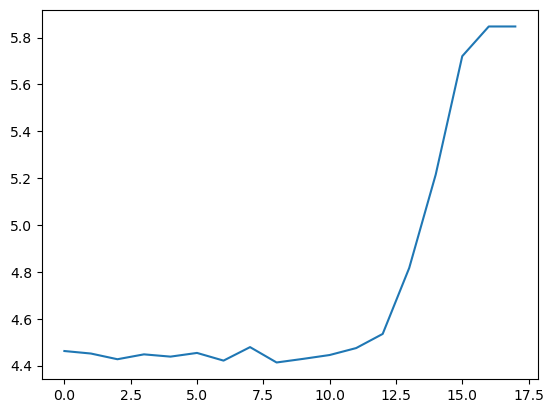

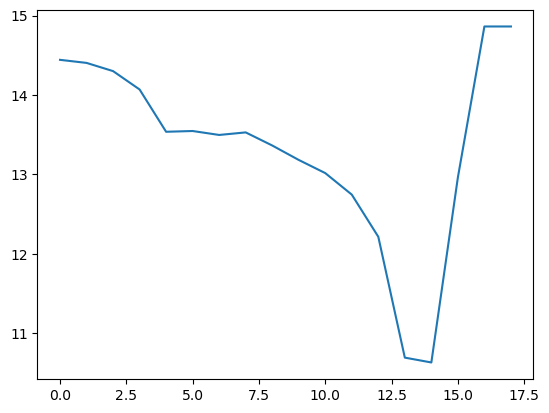

In [35]:
plt.figure()
plt.plot(np.arange(0,18), lpoints)
plt.figure()
plt.plot(np.arange(0,18), rpoints)

# Inner plate

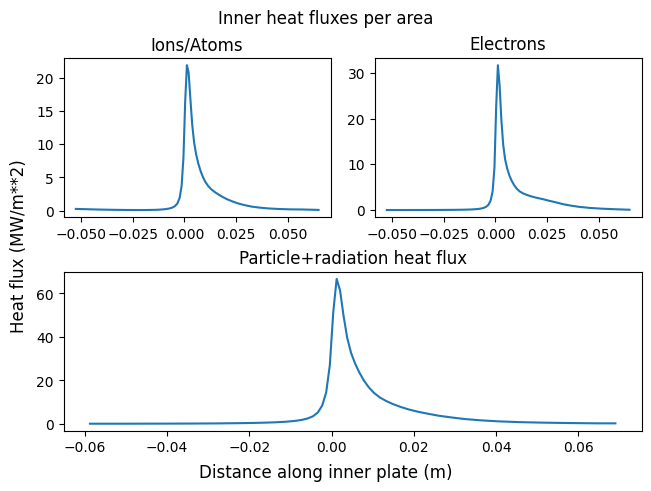

In [5]:
# %matplotlib widget
fig, axs = plt.subplot_mosaic(
    [['TopLeft', 'TopRight'],
     ['Bottom', 'Bottom']],
    layout='constrained',  # Automatically adjust layout
    width_ratios=[1, 1],   # Equal width for the top plots
)
fig.suptitle('Inner heat fluxes per area')
fig.supxlabel('Distance along inner plate (m)')
fig.supylabel('Heat flux (MW/m**2)')
# axs['TopRight'].set_xlabel("Distance along inner plate (m)")
#axs['TopRight'].set_ylabel("feex (W)")
axs['TopRight'].set_title("Electrons")
axs['TopRight'].plot(com.yylb[1:-1],-bbb.feex[0,1:-1]/com.sx[0,1:-1]*1e-6)

# axs['TopLeft'].set_xlabel("Distance along inner plate (m)")
# axs['TopLeft'].set_ylabel("Heat flux (MW/m**2)")
axs['TopLeft'].set_title("Ions/Atoms")
axs['TopLeft'].plot(com.yylb[1:-1],-bbb.feix[0,1:-1]/com.sx[0,1:-1]*1e-6) #polodal east field area

bbb.fqp=0
bbb.plateflux(); #internally calculated fluxes (postprocessing)
# axs['Bottom'].set_xlabel("Distance along inner plate (m)")
# axs['Bottom'].set_ylabel("Heat flux [MW/m**2]")
axs['Bottom'].set_title("Particle+radiation heat flux")
axs['Bottom'].plot(com.yylb,1.e-6*(bbb.sdtlb+bbb.sdrlb))
plt.show()

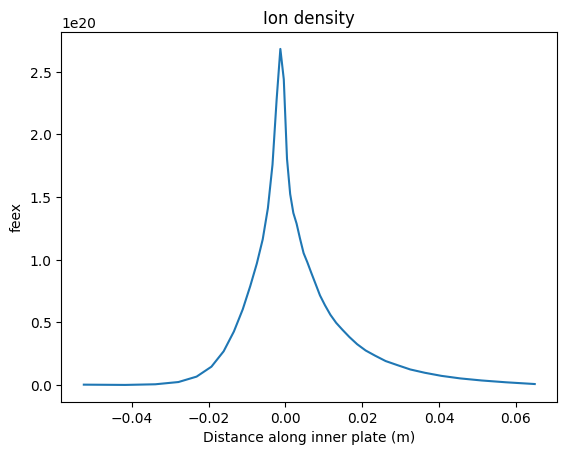

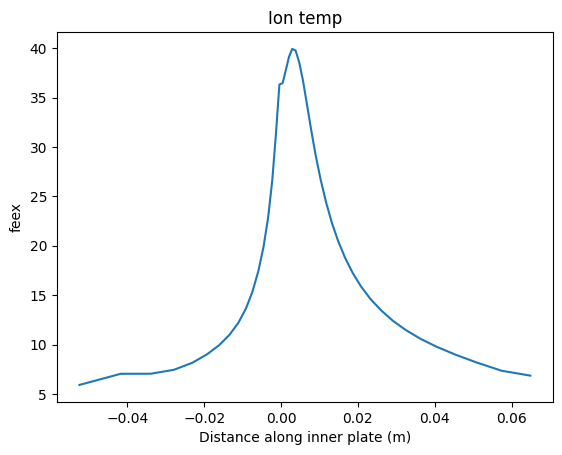

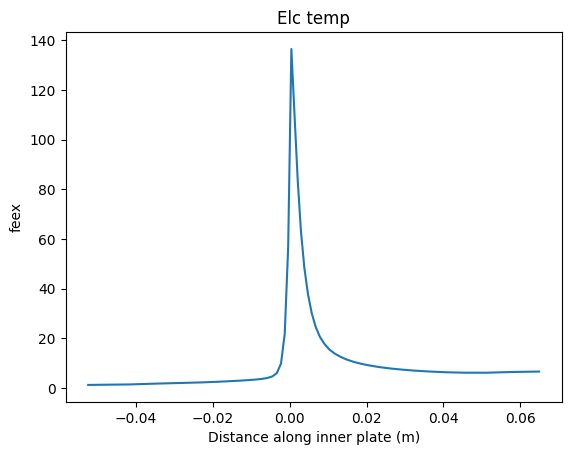

In [58]:
# %matplotlib inline
plt.cla()
plt.xlabel("Distance along inner plate (m)")
plt.ylabel("feex")
plt.title("Ion density")
plt.plot(com.yylb[1:-1],bbb.ni[0,1:-1,0])
plt.show()
plt.xlabel("Distance along inner plate (m)")
plt.ylabel("feex")
plt.title("Ion temp")
plt.plot(com.yylb[1:-1],bbb.ti[0,1:-1]/bbb.ev)
plt.show()
plt.xlabel("Distance along inner plate (m)")
plt.ylabel("feex")
plt.title("Elc temp")
plt.plot(com.yylb[1:-1],bbb.te[0,1:-1]/bbb.ev)
plt.show()

# Midplane

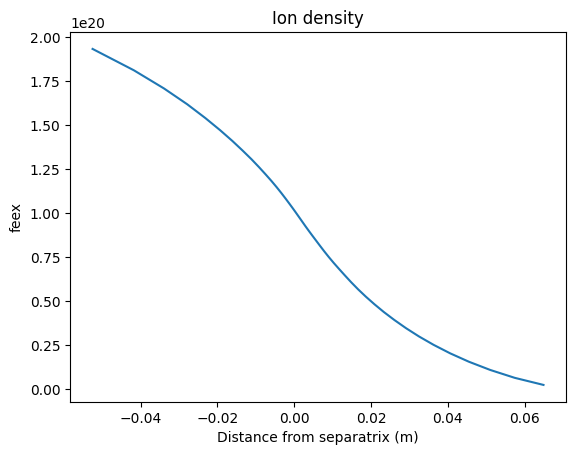

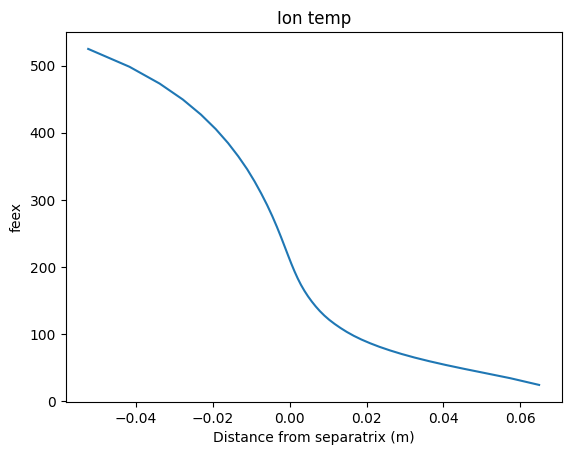

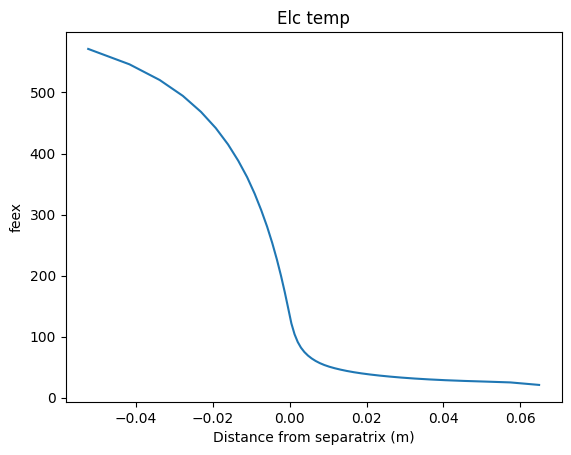

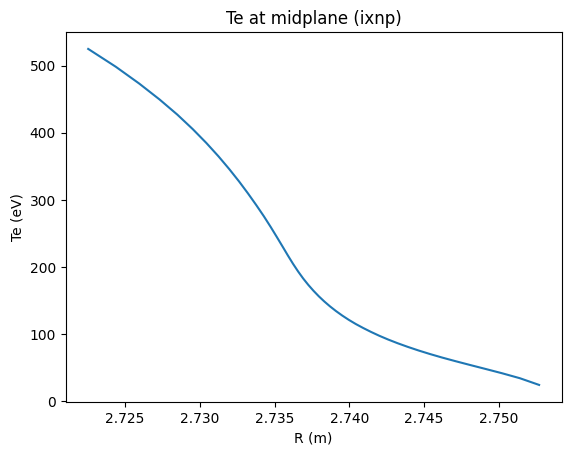

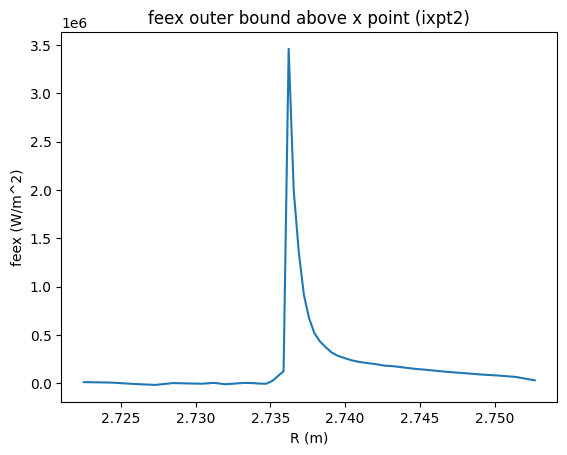

/var/folders/6k/szv1t26507x90qxy_b9b49400000gn/T/ipykernel_15600/3048560851.py:48: RuntimeWarning: overflow encountered in exp
  return np.exp(n - x / k)


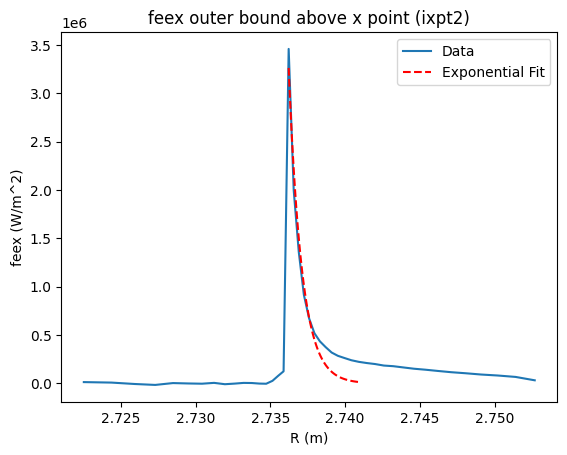

Optimized n: 3148.9067254955135
Optimized k: 0.8731041100836447


In [7]:
plt.xlabel("Distance from separatrix (m)")
plt.ylabel("feex")
plt.title("Ion density")
plt.plot(com.yylb[1:-1],bbb.ni[bbb.ixmp,1:-1,0])
plt.show()
plt.xlabel("Distance from separatrix (m)")
plt.ylabel("feex")
plt.title("Ion temp")
plt.plot(com.yylb[1:-1],bbb.ti[bbb.ixmp,1:-1]/bbb.ev)
plt.show()
plt.xlabel("Distance from separatrix (m)")
plt.ylabel("feex")
plt.title("Elc temp")
plt.plot(com.yylb[1:-1],bbb.te[bbb.ixmp,1:-1]/bbb.ev)
plt.show()

'''#for heat flux wall mapping fix with Filippo's method
plt.xlabel("Distance from separatrix (m)")
plt.ylabel("feix (W/m^2)")
plt.title("Ion temp * Bpol/Btot")
plt.plot(com.yylb[1:-1],bbb.ti[com.ixpt2[0],1:-1].T/bbb.ev*((com.bpol[com.ixpt2[0],1:-1,0]/com.b[com.ixpt2[0],1:-1,0])))
plt.show()
plt.xlabel("Distance from separatrix (m)")
plt.ylabel("feex (W/m^2)")
plt.title("Elc temp * Bpol/Btot")
plt.plot(com.yylb[1:-1],bbb.te[com.ixpt2[0],1:-1].T/bbb.ev*((com.bpol[com.ixpt2[0],1:-1,0]/com.b[com.ixpt2[0],1:-1,0])))
plt.show()'''

#For length scale 
rad = [arr[0] for arr in com.rm[bbb.ixmp, 1:-1]] #average index 2 and 4 for arr

plt.xlabel("R (m)")
plt.ylabel("Te (eV)")
plt.title("Te at midplane (ixnp)")
plt.plot(rad,bbb.ti[bbb.ixmp,1:-1]/bbb.ev)
plt.show()
plt.xlabel("R (m)")
plt.ylabel("feex (W/m^2)")
plt.title("feex outer bound above x point (ixpt2)")
plt.plot(rad,bbb.feex[com.ixpt2[0],1:-1])
plt.show()

import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

def exponential_func(x, n, k):
    return np.exp(n - x / k)

x_data = rad
y_data = bbb.feex[com.ixpt2[0], 1:-1]

x_data_outward = x_data[17:30]
y_data_outward = y_data[17:30]

try:
    popt, pcov = curve_fit(exponential_func, x_data_outward, y_data_outward, p0=[np.log(y_data_outward[0]), 1], maxfev=10000)
    
    plt.xlabel("R (m)")
    plt.ylabel("feex (W/m^2)")
    plt.title("feex outer bound above x point (ixpt2)")
    plt.plot(x_data, y_data, label="Data")
    x_fit = np.linspace(min(x_data_outward), max(x_data_outward), 100)
    y_fit = exponential_func(x_fit, *popt)
    plt.plot(x_fit, y_fit, 'r--', label="Exponential Fit")
    plt.legend()
    plt.show()

except RuntimeError as e:
    print("Curve fitting did not converge:", e)

n_opt, k_opt = popt
print(f"Optimized n: {n_opt}")
print(f"Optimized k: {k_opt*1000}") 

# Outer plate

<Figure size 640x480 with 0 Axes>

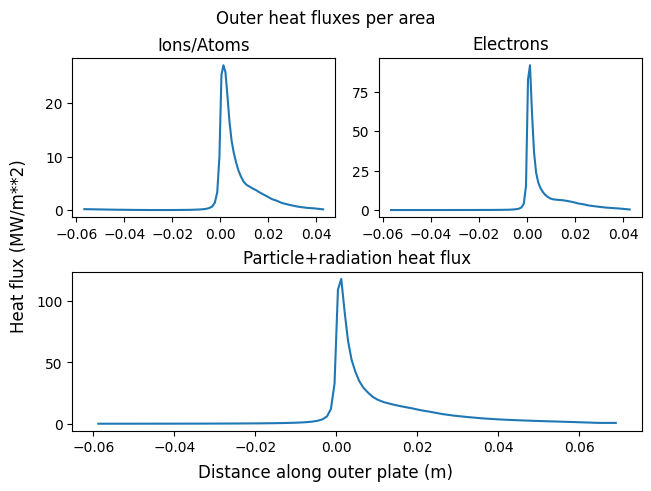

array([117.95200226])

In [9]:
# total convective and conductive heat flux
# 2nd char: e for energy n for particle
plt.figure()
fig, axs = plt.subplot_mosaic(
    [['TopLeft', 'TopRight'],
     ['Bottom', 'Bottom']],
    layout='constrained',  # Automatically adjust layout
    width_ratios=[1, 1],   # Equal width for the top plots
)
fig.suptitle('Outer heat fluxes per area')
fig.supxlabel('Distance along outer plate (m)')
fig.supylabel('Heat flux (MW/m**2)')
# axs['TopRight'].set_xlabel("Distance along inner plate (m)")
#axs['TopRight'].set_ylabel("feex (W)")
axs['TopRight'].set_title("Electrons")
axs['TopRight'].plot(com.yyrb[1:-1],bbb.feex[com.nx,1:-1]/com.sx[0,1:-1]*1e-6)

# axs['TopLeft'].set_xlabel("Distance along inner plate (m)")
# axs['TopLeft'].set_ylabel("Heat flux (MW/m**2)")
axs['TopLeft'].set_title("Ions/Atoms")
axs['TopLeft'].plot(com.yyrb[1:-1],bbb.feix[com.nx,1:-1]/com.sx[0,1:-1]*1e-6) #polodal east field area

bbb.fqp=0
bbb.plateflux(); #internally calculated fluxes (postprocessing)
# axs['Bottom'].set_xlabel("Distance along inner plate (m)")
# axs['Bottom'].set_ylabel("Heat flux [MW/m**2]")
axs['Bottom'].set_title("Particle+radiation heat flux")
axs['Bottom'].plot(com.yylb,1.e-6*(bbb.sdtrb+bbb.sdrrb))
plt.show()
max(1.e-6*(bbb.sdtrb+bbb.sdrrb))

In [15]:
bbb.gamsec

0.0

# 2D Plots

<Figure size 640x480 with 0 Axes>

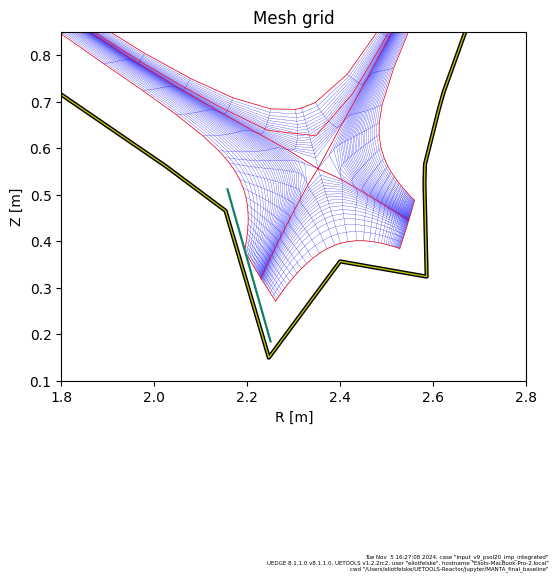

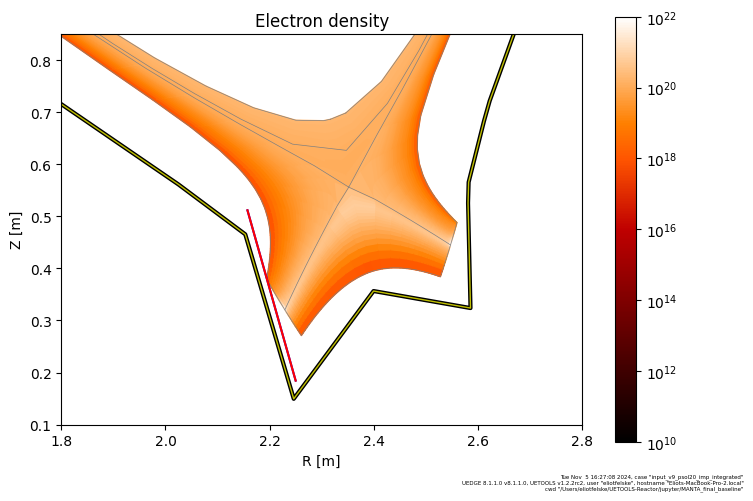

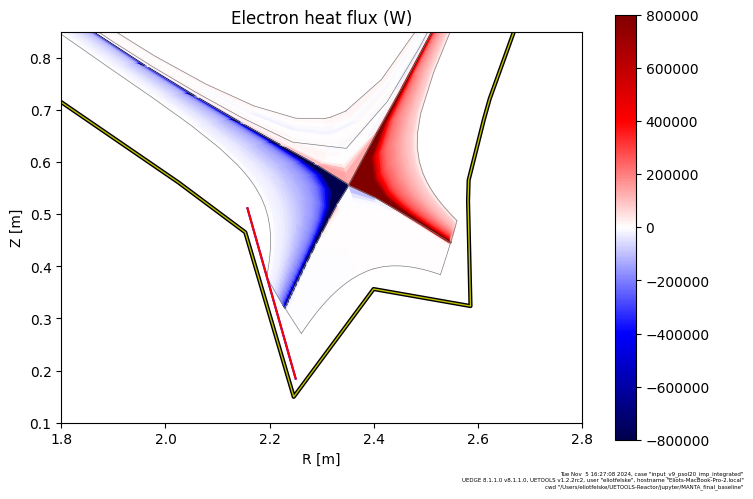

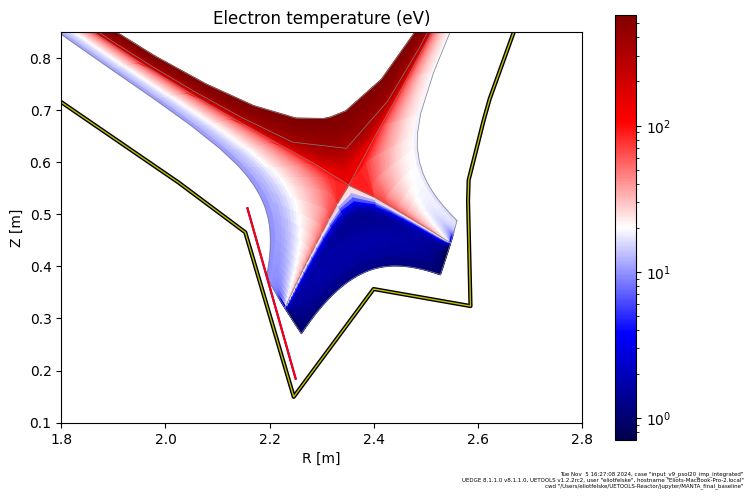

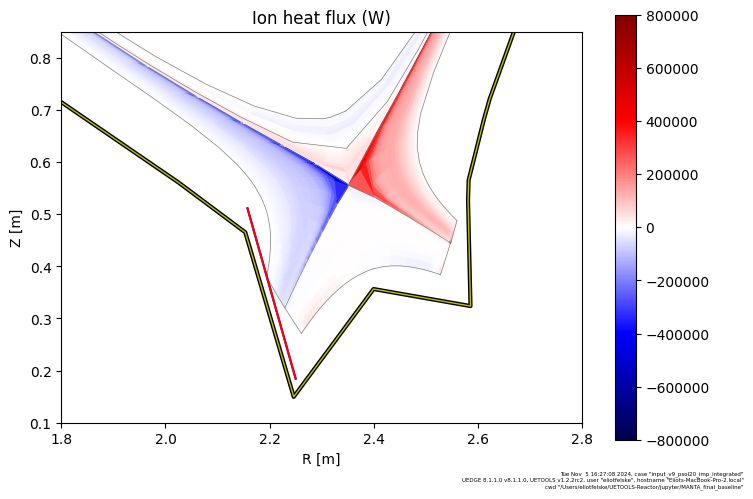

In [10]:
plt.figure()

c.plot.grid(linewidth=0.1, #grid plot
   vessel=True, 
   plates=True, 
   platecolor=['gold','teal'], 
   lcfs=True, 
   xlim=(1.8, 2.8), 
   ylim=(0.1,0.85),
   lcfscolor='r', 
   linecolor='b',
   title='Mesh grid'
  );

c.plot.mesh(
    bbb.ne, 
    log=True, 
    xlim=(1.8, 2.8), 
    ylim=(0.1,0.85),
    figsize=(7,5), 
    zrange=(1e10,1e22), 
    cmap='gist_heat',
    title='Electron density'
);


c.plot.mesh(
    bbb.feex, 
    xlim=(1.8, 2.8), 
    ylim=(0.1,0.85), 
    figsize=(7,5), 
    zrange=(-8e5,8e5),
    cmap='seismic',
    title='Electron heat flux (W)'
);
c.plot.mesh(
    bbb.te/bbb.ev, 
    log=True, 
    xlim=(1.8, 2.8), 
    ylim=(0.1,0.85), 
    figsize=(7,5), 
    # zrange=(-5e5,5e5),
    cmap='seismic',
    title='Electron temperature (eV)'
);
c.plot.mesh(
    bbb.feix, 
    xlim=(1.8, 2.8), 
    ylim=(0.1,0.85),
    figsize=(7,5), 
    zrange=(-8e5,8e5),
    cmap='seismic',
    title='Ion heat flux (W)'
);
'''
c.plot.mesh(
    bbb.dif_use[:,:,0], 
    # log=True, 
    xlim=(1.8, 2.8), 
    ylim=(0.1,0.85),
    figsize=(7,5), 
    # zrange=(.42,.48), 
    cmap='gist_heat',
    title='Diffusion'
);
# dif_use=0.5=kyi=kye
#tray_use=0.0
c.plot.mesh(
    bbb.tray_use[:,:,0], 
    # log=True, 
    xlim=(1.8, 2.8), 
    ylim=(0.1,0.85),
    figsize=(7,5), 
    # zrange=(.42,.48), 
    cmap='gist_heat',
    title='tray'
);
c.plot.mesh(
    bbb.kye_use, 
    # log=True, 
    xlim=(1.8, 2.8), 
    ylim=(0.1,0.85), 
    figsize=(7,5), 
    # zrange=(.42,.48), 
    cmap='gist_heat',
    title='kyi_use'
);
'''
plt.show()

20000000.0

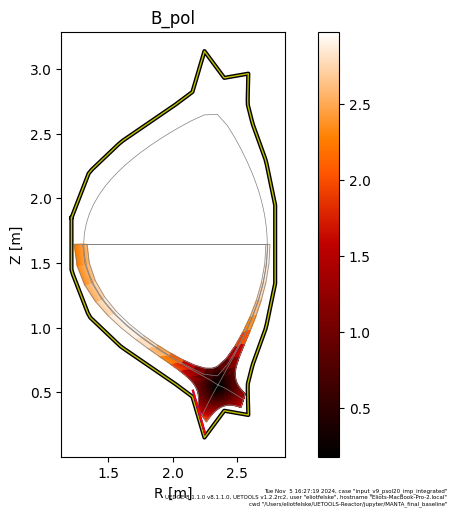

In [11]:
bpol = com.bpol[:,:,0]
c.plot.mesh(
    bpol, 
    # log=True, 
    figsize=(7,5),
    # ylim=(0,1.5) ,
    # zrange=(.42,.48), 
    cmap='gist_heat',
    title='B_pol'
);

bbb.pcorei

In [22]:
c.search.var("te")
c.search.var("ncore")


Package:    bbb
Group:      Compla
Attributes: Compla 
Dimension:  (0:nx+1,0:ny+1)
            (66, 46)
Type:       double
Address:    5303892480
Pyaddress:  5041645744
Unit:       J
Comment:
electron temperature in primary cell
Package:    bbb
Group:      Bcond
Attributes: Bcond restart input 
Dimension:  (31)
            (31)
Type:       double
Address:    5049154480
Pyaddress:  5041316624
Unit:       m**-3
Comment:
core ion dens if isnicore=1


In [6]:
(c.tools.hdf5search("gridue_v9.hdf5", "bpol")[1:-1,1:-1]/c.tools.hdf5search("gridue_v7.hdf5", "bpol")[1:-1,1:-1]).min()

np.float64(0.34848328109775634)

In [50]:
print(grd.rplate1,grd.rplate2,grd.zplate1,grd.zplate1)

[2.1575 2.25  ] [2.1575 2.25  ] [0.51150784 0.18450784] [0.51150784 0.18450784]
